In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

In [2]:
"""
We will be analyzing the MNIST Digits Dataset, and attempt to fit a simple logistic regression model to classify whether
a given digit is '1' or '5'.

We create 2 features for an image:
- Symmetry
- Mean Intensity

We define symmetry as the as the average of the difference between an image and its flipped version along the horizontal axis,
and the difference between an image and its flipped version along the vertical axis.

We define the mean intensity as the mean intensity of the whole image.



Results:

We achieve an in sample accuracy of 96.28% and an out of sample accuracy of 82.23%
"""
#

"\nWe will be analyzing the MNIST Digits Dataset, and attempt to fit a simple logistic regression model to classify whether\na given digit is '1' or '5'.\n\nWe create 2 features for an image:\n- Symmetry\n- Mean Intensity\n\nWe define symmetry as the as the average of the difference between an image and its flipped version along the horizontal axis,\nand the difference between an image and its flipped version along the vertical axis.\n\nWe define the mean intensity as the mean intensity of the whole image.\n\n\n\nResults:\n\nWe achieve an in sample accuracy of 96.28% and an out of sample accuracy of 82.23%\n"

In [10]:
#Import and process dataframe
train = pd.read_csv("ZipDigits.train")
test = pd.read_csv("ZipDigits.test")

def process(row):
    img = row.to_numpy()
    img = np.array(img[0].split(), dtype=np.float32)
    label = int(img[0])
    img = img[1:257].reshape((16,16))
    return pd.Series({'label': label, 'img': img})
    
train = train.apply(process,axis=1)
test = test.apply(process,axis=1)

train = train[(train['label'] == 5) | (train['label'] == 1)].reset_index()
test = test[(test['label'] == 5) | (test['label'] == 1)].reset_index()

train = train.rename(columns={0: 'img'})
test = test.rename(columns={0: 'img'})

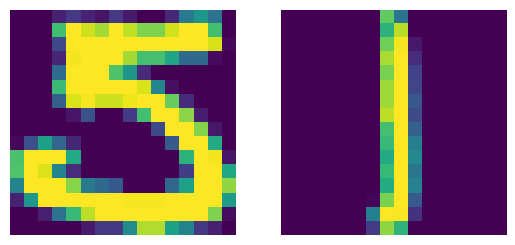

In [11]:
#Sample '1' and '5'
f, ax = plt.subplots(ncols = 2)
ax[0].imshow(train.loc[0,'img'])
ax[1].imshow(train.loc[1,'img'])
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [14]:
#Define features of the image (Symmetry and Mean Intensity)
train['mean_intensity'] = train['img'].apply(lambda x: np.mean(x))
train['symmetry'] = train['img'].apply(lambda x: -np.mean([np.abs(x-np.flip(x,axis=1)), np.abs(x-np.flip(x,axis=0))]))
test['mean_intensity'] = test['img'].apply(lambda x: np.mean(x))
test['symmetry'] = test['img'].apply(lambda x: -np.mean([np.abs(x-np.flip(x,axis=1)), np.abs(x-np.flip(x,axis=0))]))
test

,index,label,img,mean_intensity,symmetry
0,15,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.586, ...",-0.680133,-0.217750
1,31,5,"[[-1.0, -1.0, -1.0, -1.0, -0.933, 0.461, 0.779...",-0.350320,-0.795070
2,35,5,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",-0.497641,-0.548672
3,41,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0....",-0.750781,-0.059305
4,44,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.219, 0...",-0.561766,-0.113063
...,...,...,...,...,...
419,1987,5,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",-0.108152,-0.667945
420,1988,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -0.999, 0.562,...",-0.645996,-0.119492
421,1991,5,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -0.565, 0.388,...",-0.230039,-0.635750
422,1997,5,"[[-1.0, -1.0, -1.0, -0.885, -0.28, -0.411, -0....",-0.320828,-0.590359


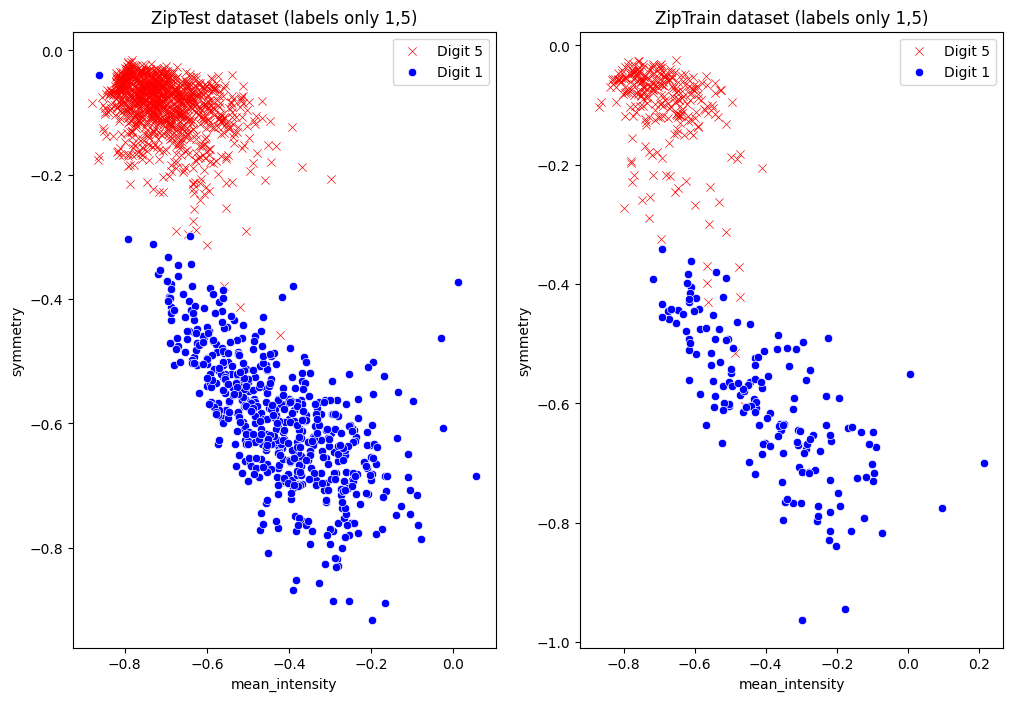

In [33]:
#Plot digit 5 and digit 1 labels
f, ax = plt.subplots(ncols=2, figsize = (12,8))
sns.scatterplot(data = train[train['label'] == 1], x = 'mean_intensity', y = 'symmetry', marker='x', color='red', label='Digit 5', ax=ax[0])
sns.scatterplot(data = train[train['label'] == 5], x = 'mean_intensity', y = 'symmetry', marker='o', color='blue', label='Digit 1', ax=ax[0])
sns.scatterplot(data = test[test['label'] == 1], x = 'mean_intensity', y = 'symmetry', marker='x', color='red', label='Digit 5', ax=ax[1])
sns.scatterplot(data = test[test['label'] == 5], x = 'mean_intensity', y = 'symmetry', marker='o', color='blue', label='Digit 1', ax=ax[1])
ax[0].set_title("ZipTest dataset (labels only 1,5)")
ax[1].set_title("ZipTrain dataset (labels only 1,5)")
plt.show()

In [50]:
x = train[['mean_intensity','symmetry']].to_numpy()
y = train['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
w = np.random.uniform(low=0, high=1, size=x.shape[1])

def gradient_e_in(w, x, y):
    wTx = x @ w
    sigmoid = np.exp(-y * wTx)/(1+np.exp(-y * wTx))
    y = y[:, np.newaxis]
    sigmoid = sigmoid[:, np.newaxis]
    grad = -np.sum((y * x) * sigmoid, axis=0)/(x.shape[0])
    return grad
    
def e_in(w, x, y):
    y = y[:, np.newaxis]
    wTx = x @ w
    ein = np.mean(np.logaddexp(0, -y * wTx))
    return ein

def logistic_regression(w, x, y, eta, iterations):
    min_loss_weights = np.zeros(x.shape[1])
    ein = float('inf')
    for _ in range(iterations):
        grad = gradient_e_in(w,x,y)
        loss = e_in(w,x,y)
        if(ein > loss):
            ein = loss
            min_loss_weights = w.copy()
        w += eta*-grad
    return min_loss_weights

w_optimal = logistic_regression(w,x,y,0.1,500)

In [51]:
w_optimal

array([-0.80437984,  0.70472016])

In [65]:
print("E_in: " + str(e_in(w_optimal, x, y)))

x_ = test[['mean_intensity','symmetry']].to_numpy()
y_ = test['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()

print("E_out: " + str(e_in(w_optimal, x_, y_)))

E_in: 0.6729508818672146
E_out: 0.6825885160805333


In [66]:
#Calculate in sample accuracy
sigmoid = lambda w,x: np.exp(x @ w)/(1+np.exp(x @ w))
in_sample_predictions = sigmoid(w, x)
in_sample_predictions = np.where(in_sample_predictions >= 0.5, 1, -1)

y_true = train['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
in_sample_accuracy = np.mean(in_sample_predictions == y_true)
in_sample_accuracy

np.float64(0.9590006406149904)

In [67]:
# Set up test
test['mean_intensity'] = test['img'].apply(lambda x: np.mean(x))
test['symmetry'] = test['img'].apply(lambda x: -np.mean([np.abs(x-np.flip(x,axis=1)), np.abs(x-np.flip(x,axis=0))]))

x_test = test[['mean_intensity', 'symmetry']].to_numpy()
out_sample_predictions = sigmoid(w_optimal, x_test)
out_sample_predictions = np.where(out_sample_predictions >= 0.5, 1, -1)

y_true = test['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
out_sample_predictions = np.mean(out_sample_predictions == y_true)
out_sample_predictions

np.float64(0.8773584905660378)

In [71]:
vc_bound = lambda delta, d_vc, n: np.sqrt(8/n * np.log((4*((2*n)**d_vc + 1))/delta))

print("E_out based on E_in bound: " + str(vc_bound(0.05,3,train.shape[0])))
print("E_out based on E_test bound: " + str(vc_bound(0.05,0,test.shape[0])))

E_out based on E_in bound: 0.38231711324801476
E_out based on E_test bound: 0.30944788981966864
